# Centralized training: defining the upper bound

In [ ]:
#-- LIBRARIES
import random
from datetime import datetime

import pandas as pd

import torch
from torch.optim import SGD
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.models import resnet50
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip

import matplotlib.pyplot as plt

import numpy as np

from google.colab import files

In [ ]:
#-- SELECTING THE PROCESSOR
if torch.cuda.is_available():  
  device = "cuda:0"
else:  
  device = "cpu"

In [ ]:
#-- CREATING THE DATAFRAME TO REGISTER STATS
stats_file = 'progress-BN.csv'
stats = pd.DataFrame(columns=['epoch', 'batch', 'loss', 'accuracy'])
try:
    stats = pd.read_csv(stats_file)
except:
    pass    

In [ ]:
#-- DEFINING METHODS TO MODIFY STATS FILE
def register_progress(epoch, batch=None, loss=None, accuracy=None):
    idx = len(stats)
    stats.loc[idx] = [epoch, batch, loss, accuracy]

def save_progress():
    stats.to_csv(stats_file, header=True, index=False)

## Defining Methods

In [ ]:
#-- DEFINING TRAINING LOOP
def train(data_loader, model, loss_fn, optm, epoch):
    model.train() # train mode
    model.to(torch.device(device)) # send it to device
    size = len(data_loader.dataset)
    for batch_num, (X,y) in enumerate(data_loader):
        X = X.to(torch.device(device))
        y = y.to(torch.device(device))
        optm.zero_grad()
        pred = model(X)
        print(y[0])
        print(pred[0])
        print("---")
        loss = loss_fn(pred, y)
        loss.backward()
        optm.step()
        if batch_num %100 == 0:
          register_progress(epoch, batch_num, loss.item())

In [ ]:
#-- DEFINING TEST LOOP
def test(dataloader, model, epoch):
    model.eval()
    size = 0
    correct = 0
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(torch.device(device))
            y = y.to(torch.device(device))
            outs = model(X)
            _, pred = torch.max(outs.data, 1)
            size += y.size(0)
            correct += (pred == y).sum().item()
    correct /= size
    register_progress(epoch, accuracy=correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%\n")


In [ ]:
#-- DEFINE METHOD TO SET GROUP NORMALIZATION
def bn_to_gn(layer, num_groups):
    for name, _ in layer.named_modules():
        if name:
            try:
                sub_layer = getattr(layer, name)
                if isinstance(sub_layer, nn.BatchNorm2d):
                    num_channels = sub_layer.num_features
                    layer._modules[name] = nn.GroupNorm(num_groups, num_channels)
            except AttributeError:
                name = name.split('.')[0]
                sub_layer = getattr(layer, name)
                sub_layer = bn_to_gn(sub_layer, num_groups)
                layer.__setattr__(name=name, value=sub_layer)
    return layer

## Training the NN on CIFAR10

In [ ]:
#-- DEFINING HYPERPARAMS, MODEL, LOSS AND OPTIMIZER
learning_rate = 1e-3
epochs = 10
batch = 128
model = resnet50(num_classes=10)
#bn_to_gn(model, 2) #Comment this to use BN
optm = SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#-- LOADING DATASET
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([
            RandomHorizontalFlip(),
            RandomCrop(32, 4),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
        ])
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
        ])
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
            'ship', 'truck')

train_dataloader = DataLoader(training_data, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


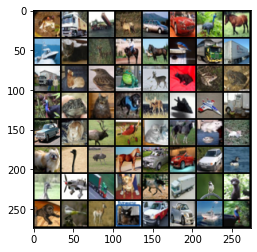

In [ ]:
#-- PRINTING ONE DATASET BATCH
def show_images(images, nmax=64):
    batch = torch.tensor(images[:nmax]).permute(0,3,1,2)
    plt.imshow(make_grid(batch, nrow=8).permute(1, 2, 0))
show_images(training_data.data)

In [ ]:
#-- LOADING THE NET IF EXISTS
model_file = 'central-resnet50'
try:
    model.load_state_dict(torch.load(model_file))
except:
    pass

In [ ]:
#-- TRAINING THE NET
last_epoch = np.nan_to_num(stats['epoch'].max())
last_epoch = int(last_epoch) + 1
for epoch in range(last_epoch, epochs + last_epoch):
    print(f"Epoch {epoch}\n-------")
    train(train_dataloader, model, loss_fn, optm, epoch)
    test(test_dataloader, model, epoch)

Streaming output truncated to the last 5000 lines.
---
tensor(8, device='cuda:0')
tensor([ 1.2694,  0.1036, -0.2462, -0.6256, -0.6359, -0.9653, -2.4982, -0.0599,
         2.4231,  0.5626], device='cuda:0', grad_fn=<SelectBackward0>)
---
tensor(4, device='cuda:0')
tensor([-0.5785, -0.1201,  1.1485,  0.6607,  1.1685,  0.5988,  1.2239,  0.1433,
        -1.3872, -1.3330], device='cuda:0', grad_fn=<SelectBackward0>)
---
tensor(0, device='cuda:0')
tensor([ 0.9544, -1.2647,  0.2667, -1.5014, -0.7719, -0.6110, -2.3033, -2.2920,
         0.2640, -2.6937], device='cuda:0', grad_fn=<SelectBackward0>)
---
tensor(4, device='cuda:0')
tensor([-1.2033, -1.1381,  1.3391,  0.0041,  2.0684, -0.2599,  1.8829,  0.5690,
        -2.0092, -0.9466], device='cuda:0', grad_fn=<SelectBackward0>)
---
tensor(7, device='cuda:0')
tensor([ 0.1448, -0.3172,  0.0513, -1.0898, -0.3948, -0.6509, -1.1586,  0.6689,
         0.7377,  0.8354], device='cuda:0', grad_fn=<SelectBackward0>)
---
tensor(8, device='cuda:0')
tensor([

In [ ]:
#-- SAVING THE MODEL AND STATS
torch.save(model.state_dict(), model_file)
save_progress()
files.download(model_file)
files.download(stats_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pred: cat, Real: cat


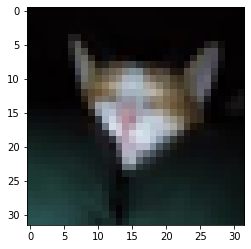

In [ ]:
#-- MANUAL TESTING
i = random.randint(0, len(test_data))
y = test_data[i][1]
plt.imshow(test_data.data[i])
with torch.no_grad():
    model.eval()
    X = test_data[i][0].unsqueeze(0).to(torch.device(device))
    pred = model(X).argmax(1).item()
    print(f"Pred: {classes[pred]}, Real: {classes[y]}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


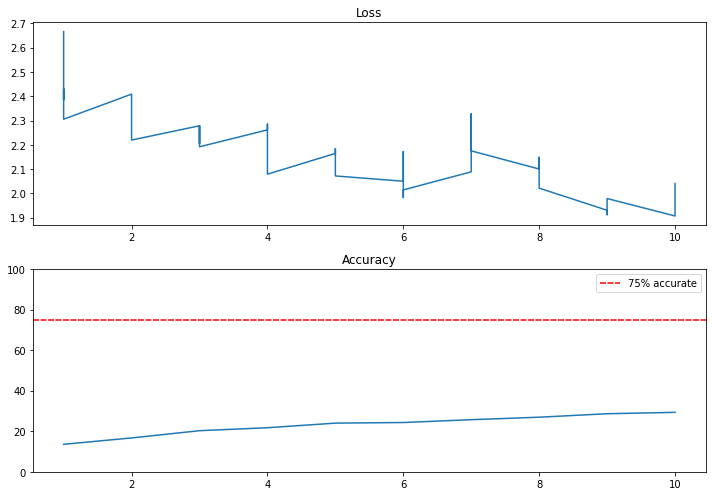

In [ ]:
df_loss = stats.drop('accuracy', 1)
df_loss = df_loss.dropna()

df_acc = stats.drop(['loss', 'batch'], 1)
df_acc = df_acc.dropna()

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(10,7)
axs[0].set_title('Loss')
axs[0].plot(df_loss['epoch'], df_loss['loss'])
axs[1].set_title('Accuracy')
axs[1].set_ylim((0,100))
axs[1].axhline(75, dashes=(4,1), color='red', label='75% accurate')
axs[1].plot(df_acc['epoch'], df_acc['accuracy'] * 100)
axs[1].legend()
fig.tight_layout()